<a href="https://colab.research.google.com/github/danilodioliveira/Health-Insurance/blob/main/pa004_health_insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Health Insurance**

https://sejaumdatascientist.com/como-usar-data-science-para-fazer-a-empresa-vender-mais/

# Features Descriptions



# <font color = 'green'> **Ciclo 01** 

# 0.0. Imports

In [ ]:
# !pip install --upgrade pip

In [1]:
!pip install inflection;
!pip install boruta;
!pip install git+https://github.com/psycopg/psycopg3.git#subdirectory=psycopg3;
!pip install scikit-plot

     |████████████████████████████████| 61kB 4.1MB/s 
  Cloning https://github.com/psycopg/psycopg3.git to /tmp/pip-req-build-cxm43_dv
  Running command git clone -q https://github.com/psycopg/psycopg3.git /tmp/pip-req-build-cxm43_dv
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for psycopg3: filename=psycopg3-2.99.0-cp36-none-any.whl size=95299 sha256=031bbaa74b525dbd08bad4899473446da4f2513419621063566833f9836c94c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-7y9g9iio/wheels/5d/71/20/44e6b983287db648ab1c4eeffef99a656208828a8879b2577c
Successfully built psycopg3


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
                                
                                
                                import pickle
                                import psycopg3
                                import joblib
                                import warnings
                                import inflection

                                import numpy             as np
                                import pandas            as pd
                                import seaborn           as sns
                                import matplotlib.pyplot as plt

                                import scikitplot as skplt
from scipy                      import stats

from boruta                     import BorutaPy

from IPython.display            import Image
from IPython.core.display       import HTML 

from xgboost                    import XGBClassifier

from lightgbm                   import LGBMClassifier

from sklearn                    import preprocessing as pp
from sklearn                    import model_selection as ms
from sklearn.svm                import SVC
from sklearn.dummy              import DummyClassifier
from sklearn.ensemble           import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors          import KNeighborsClassifier
from sklearn.linear_model       import LogisticRegression

from sklearn.metrics            import balanced_accuracy_score, precision_score, classification_report
from sklearn.metrics            import recall_score, f1_score, make_scorer, cohen_kappa_score
from sklearn.preprocessing      import MinMaxScaler, RobustScaler, LabelEncoder

from sklearn.model_selection    import GridSearchCV, train_test_split, StratifiedKFold, StratifiedShuffleSplit


## 0.1. Helper Functions

## Models

In [ ]:
warnings.filterwarnings('ignore')


def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(balanced_accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        kappas.append(cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

In [ ]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, 
                        index=[model_name])



In [ ]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

In [ ]:
def corr_cramer_v(categorical_attributes):
    cat_attributes_list = categorical_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(categorical_attributes[ref],categorical_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

In [ ]:
def fine_tuned_performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(np.round(performance.mean(), 4).astype(str) + '+/-' + np.round(performance.std()*2,4).astype(str)).T
    return performance

In [ ]:
def models_train(models,x_train,y_train,x_test,y_test,predict='predict',metric='regression',verbose=1):
    metrics=pd.DataFrame()
    for model in models:
        print(model.__class__.__name__)
        model.fit(x_train,y_train)
        if predict=='predict':
            yhat=model.predict(x_test)
        elif predict=='predict_proba':
            yhat=model.predict_proba(x_test)
            yhat=yhat[:, 1]
        
        if metric=='regression':
            metrics=metrics.append(regression_metrics(model.__class__.__name__,y_test,yhat,verbose))
        elif metric=='multiClass':
            metrics=metrics.append(multi_class_metrics(model.__class__.__name__,y_test,yhat,verbose))
        elif metric=='binaryClass':
            metrics=metrics.append(binary_class_metrics(model.__class__.__name__,y_test,yhat,verbose))
            
    return metrics

In [ ]:
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance


    # Fine-tuned Model's performance function

## Graphics

In [ ]:
warnings.filterwarnings('ignore')

def display_settings():
  %matplotlib inline
  %pylab inline

  plt.style.use( 'bmh' )
  plt.rcParams['figure.figsize'] = [18,10]
  plt.rcParams['font.size'] = 20

  display( HTML( '<style>.container {width:100% !important; }</style>') )
  pd.options.display.max_columns = None
  pd.options.display.max_rows = None
  pd.set_option( 'display.expand_frame_repr', False )

  sns.set()

display_settings()

Populating the interactive namespace from numpy and matplotlib


In [ ]:
def graphic_percentage(ax,total):
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height,
                '{:1.2f}'.format(height/total*100),
                ha="center") 
    show

## Metricals

In [ ]:
def numerical_metrics(numerical_attributes):
    #ct = central tendency
    ct_mean = pd.DataFrame(numerical_attributes.apply(np.mean)).T
    ct_median = pd.DataFrame(numerical_attributes.apply(np.median)).T

    #d = dispersion
    d_std = pd.DataFrame(numerical_attributes.apply(np.std)).T
    d_min = pd.DataFrame(numerical_attributes.apply(min)).T
    d_max = pd.DataFrame(numerical_attributes.apply(max)).T
    d_range = pd.DataFrame(numerical_attributes.apply(lambda x: x.max() - x.min())).T
    d_skew = pd.DataFrame(numerical_attributes.apply(lambda x: x.skew())).T
    d_kurtosis = pd.DataFrame(numerical_attributes.apply(lambda x: x.kurtosis())).T

    na_resume = pd.concat([d_min,d_max,d_range,ct_mean,ct_median,d_std,d_skew,d_kurtosis]).T.reset_index()
    na_resume.columns=['Attributes','Min','Max','Range','Mean','Median','STD','Skew','Kurtosis']

    return na_resume

In [ ]:
def regression_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T
    
    #Accuracy
    acc = m.accuracy_score(y_val,yhat)
    accdf = pd.DataFrame([acc]).T

    #Balanced Accuracy
    balanced= m.balanced_accuracy_score(y_val,yhat)
    balanceddf = pd.DataFrame([balanced]).T

    #Kappa Metrics
    kappa= m.cohen_kappa_score(y_val, yhat)
    kappadf = pd.DataFrame([kappa]).T
    
    metrics = pd.concat([model,accdf,balanceddf,kappadf]).T.reset_index()
    metrics.columns=['Index','Model','Accuracy','Balanced Accuracy','Kappa Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Accuracy: {}'.format(acc))
        print('Balanced Accuracy: {}'.format(balanced))
        print('Kappa Score: {}'.format(kappa))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [ ]:
def multi_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #Precision Score
    precision= m.precision_score(y_val, yhat)
    precisiondf = pd.DataFrame([precision]).T
    
    #Recall Score
    recall= m.recall_score(y_val, yhat)
    recalldf = pd.DataFrame([recall]).T
    
    #F1 Score
    f1= m.f1_score(y_val, yhat)
    f1df = pd.DataFrame([f1]).T
    
    #MAtthews Correlation
    mcc=m.matthews_corrcoef(y_val,yhat)
    mccdf=pd.DataFrame([mcc])    
    
    metrics = pd.concat([model,precisiondf,recalldf,f1df,mccdf]).T.reset_index()
    metrics.columns=['Index','Model','Precision Score','Recall Score','F1 Score','Matthew Correlation Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('Precision Score: {}'.format(precision))
        print('Recall Score: {}'.format(recall))
        print('F1 Score: {}'.format(f1))
        print('Matthew Correlation Score: {}'.format(mcc))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [ ]:
def binary_class_metrics(model,y_val,yhat,verbose =1):
    
    model = pd.DataFrame([model]).T

    #AUC_ROC
    roc=m.roc_auc_score(y_val,yhat)
    rocdf=pd.DataFrame([roc])
    
    #topk Score
    knum=y_val.value_counts().count()-1
    topk=m.top_k_accuracy_score(y_val,yhat,k=knum)
    topkdf=pd.DataFrame([topk])    
    
    metrics = pd.concat([model,rocdf,topkdf]).T.reset_index()
    metrics.columns=['Index','Model','ROC AUC','Top K Score']
    metrics.drop(['Index'],axis=1)
    if verbose ==1:
        print('ROC AUC: {}'.format(roc))
        print('Top K Score: {}'.format(topk))
        #Classification Report
        print(m.classification_report(y_val,yhat))
        # Confision Matrix
        mt.plot_confusion_matrix(y_val,yhat,normalize=False,figsize=(12,12))
        
    return metrics

In [ ]:
def precision_at_k(df,score,target,perc=0.25):
    k=np.floor(len(df)*perc)
    print(k)
    df.sort_values(score,ascending=False)
    df=df.reset_index(drop=True)
    df['ranking']=df.index+1
    df['precision_at_k']=df[target].cumsum()/df['ranking']
    return df.loc[k,'precision_at_k']

In [ ]:
def recall_at_k(df,score,target,perc=0.25):
    k=np.floor(len(df)*perc)    
    df.sort_values(score,ascending=False)
    df=df.reset_index(drop=True)
    df['ranking']=df.index+1
    df['recall_at_k']=df[target].cumsum()/df[target].sum()
    return df.loc[k,'recall_at_k']

## CrossValidation

In [ ]:
def cross_validation(num_folds,modelName,model,x,y,metric):
    kfold=ms.StratifiedKFold(n_splits=num_folds,shuffle=True,random_state=seed)

    cv_rf_metrics_list=pd.DataFrame()

    i=1

    for train_cv,val_cv in kfold.split(x_train,y_train):
        print('Fold Number {}/{}'.format(i,num_folds))

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model=model_fit.predict(x_val_fold)
        #metrics = model_metrics(modelName,y_val_fold,yhat_model,0)
        cv_rf_metrics_list = cv_rf_metrics_list.append(metric('{} - {}/{}'.format(modelName,i,num_folds),y_val_fold,yhat_model,0))

        i+=1
    return cv_rf_metrics_list

## Database

In [8]:
def get_table(name):
  cur.execute( "SELECT * FROM pa004.{}".format( name) )
  cols = [ desc[0] for desc in cur.description ]

  aux = []
  for i in cur:
    aux.append(i)
  
  table = pd.DataFrame( aux, columns = cols)

  return table

## 0.2. Loading Data

### 0.2.1 Loading Path

In [4]:
path = '/content/drive/MyDrive/DataScience/Projects/Health Insurance'
# path = '/home/danilo/gitrepos/comunidade DS/pa004_health_insurance_cross_sell'

### 0.2.2 Getting the Data

In [5]:
# #  Database: Postgres 12.0 - AWS
# # Credentials:
# host = ''
# port = ''
# db = ''
# user = ''
# pw = ''
# # problema de negócio: https://sejaumdatascientist.com/como-usar-data-science-para-fazer-a-empresa-vender-mais/

In [6]:
# connection = psycopg3.connect( host = host, port = port, dbname = db, user = user, password = pw)
# cur = connection.cursor()

# cur.execute("SELECT * FROM information_schema.tables WHERE table_type = 'BASE TABLE' AND table_schema = 'pa004'")
# cols = [desc[0] for desc in cur.description ]

# tables_name = []
# for i in cur:
#     tables_name.append(i)

# tables_name = pd.DataFrame( tables_name, columns = cols)
# tables_name

,table_catalog,table_schema,table_name,table_type,self_referencing_column_name,reference_generation,user_defined_type_catalog,user_defined_type_schema,user_defined_type_name,is_insertable_into,is_typed,commit_action
0,comunidadedsdb,pa004,users,BASE TABLE,None,None,None,None,None,YES,NO,None
1,comunidadedsdb,pa004,vehicle,BASE TABLE,None,None,None,None,None,YES,NO,None
2,comunidadedsdb,pa004,insurance,BASE TABLE,None,None,None,None,None,YES,NO,None


In [9]:
# users = get_table( tables_name['table_name'][0] )
# vehicle = get_table( tables_name['table_name'][1] )
# insurance = get_table(tables_name['table_name'][2] )



In [10]:
# df_raw = users.merge( vehicle, how = 'inner', on = 'id' )
# df_raw = df_raw.merge(insurance, how = 'inner', on = 'id' )
# df_raw.sample(3)

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
195220,195221,Female,31,41.0,156.0,1,< 1 Year,Yes,0,47458.0,260,0
241845,241846,Male,43,28.0,26.0,1,1-2 Year,Yes,0,2630.0,284,0
256182,256183,Female,28,15.0,152.0,1,< 1 Year,No,1,38528.0,124,0


In [12]:
df_raw.to_csv(path+'/Data/df_raw.csv', index_label = False)

## 0.3. Spliting into Train, Validation and Test

In [13]:
df_raw['response'].value_counts(normalize = True)

0    0.877437
1    0.122563
Name: response, dtype: float64

In [14]:
# apply stratified sampling
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=50)

for train_1_index, train_2_index in split.split(df_raw, df_raw['response']):
  strat_train_set = df_raw.loc[train_1_index]
  strat_test_set = df_raw.loc[train_2_index]

In [15]:
strat_train_set['response'].value_counts(normalize = True)

0    0.877437
1    0.122563
Name: response, dtype: float64

In [16]:
strat_train_set['response'].value_counts(normalize = True)

0    0.877437
1    0.122563
Name: response, dtype: float64

In [17]:
strat_test_set.to_csv(path+'/Data/test.csv')
strat_train_set.to_csv(path+'/Data/train.csv')

# 1.0. Data Description

In [ ]:
df1 = pd.read_csv(path+'/Data/train.csv')

## 1.1. Rename Columns

In [ ]:
df1.columns = ('Index', 'id', 'gender', 'age', 'region_code',
       'policy_sales_channel', 'driving_license', 'vehicle_age',
       'vehicle_damage', 'previously_insured', 'annual_premium', 'vintage',
       'response')

In [ ]:
df1.columns

Index(['Index', 'id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [ ]:
# cols_old = ('step', 'type', 'amount', 'nameOrig', 'oldbalanceOrig', 'newbalanceOrig',
#        'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
#        'isFlaggedFraud')

In [ ]:
# snakecase = lambda x: inflection.underscore( x)

# cols_new = list(map( snakecase, cols_old) )

# df1.columns = cols_new
# df1.columns

## 1.2. Data Dimensions

In [ ]:
print('The dataset has {} columns'.format(df1.shape[1] ) )
print('The dataset has {} rows'.format(df1.shape[0] ) )

The dataset has 13 columns
The dataset has 304887 rows


## 1.3. Data Type

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304887 entries, 0 to 304886
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Index                 304887 non-null  int64  
 1   id                    304887 non-null  int64  
 2   gender                304887 non-null  object 
 3   age                   304887 non-null  int64  
 4   region_code           304887 non-null  float64
 5   policy_sales_channel  304887 non-null  float64
 6   driving_license       304887 non-null  int64  
 7   vehicle_age           304887 non-null  object 
 8   vehicle_damage        304887 non-null  object 
 9   previously_insured    304887 non-null  int64  
 10  annual_premium        304887 non-null  float64
 11  vintage               304887 non-null  int64  
 12  response              304887 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 30.2+ MB


In [ ]:
df1.sample(2)

,Index,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
11976,78535,78536,Male,46,29.0,26.0,1,1-2 Year,Yes,0,41839.0,224,0
4572,39835,39836,Female,39,47.0,124.0,1,1-2 Year,Yes,0,39636.0,80,0


## 1.4. Change Types

In [ ]:

# no change needed

## 1.5. NA Check

In [ ]:
df1.isna().sum()

Index                   0
id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.6. Fillout NA

## 1.7. Check Balanced Data

In [ ]:
df1['response'].value_counts( normalize = True)

0    0.877437
1    0.122563
Name: response, dtype: float64

## 1.8. Desciptive Statistical

In [ ]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64'] )

### 1.8.1 Numerical Attributes

In [ ]:
describe = num_attributes.describe().T


describe['range'] = num_attributes.max() - num_attributes.min().tolist()
describe['variation_coefficicient'] = (num_attributes.std() / num_attributes.mean() ). tolist()
describe['skew'] = num_attributes.skew().tolist()
describe['kurtosis'] = num_attributes.kurtosis().tolist()

describe


,count,mean,std,min,25%,50%,75%,max,range,variation_coefficicient,skew,kurtosis
Index,304887.0,190469.287867,110012.850032,0.0,95109.5,190493.0,285644.5,381108.0,381108.0,0.577588,0.001695,-1.199979
id,304887.0,190470.287867,110012.850032,1.0,95110.5,190494.0,285645.5,381109.0,381108.0,0.577585,0.001695,-1.199979
age,304887.0,38.816824,15.511210,20.0,25.0,36.0,49.0,85.0,65.0,0.399600,0.674576,-0.561449
region_code,304887.0,26.384057,13.241390,0.0,15.0,28.0,35.0,52.0,52.0,0.501871,-0.114434,-0.870994
policy_sales_channel,304887.0,112.039907,54.195320,1.0,29.0,132.0,152.0,163.0,162.0,0.483714,-0.900285,-0.969907
driving_license,304887.0,0.997858,0.046230,0.0,1.0,1.0,1.0,1.0,1.0,0.046329,-21.538540,461.911732
previously_insured,304887.0,0.458176,0.498249,0.0,0.0,0.0,1.0,1.0,1.0,1.087460,0.167884,-1.971828
annual_premium,304887.0,30565.491218,17249.584623,2630.0,24412.0,31660.0,39382.0,540165.0,537535.0,0.564348,1.878145,36.970947
vintage,304887.0,154.425348,83.686999,10.0,82.0,154.0,227.0,299.0,289.0,0.541925,0.001215,-1.200798
response,304887.0,0.122563,0.327936,0.0,0.0,0.0,0.0,1.0,1.0,2.675643,2.301907,3.298797


<font color = 'red'> refazer após usar todo o dataset

*   The mean of the response variable is 0.12, which means the sells are not going good.
*   The yongest person is 20 years old, and the oldest is 85.
*   Only 45% had insurance


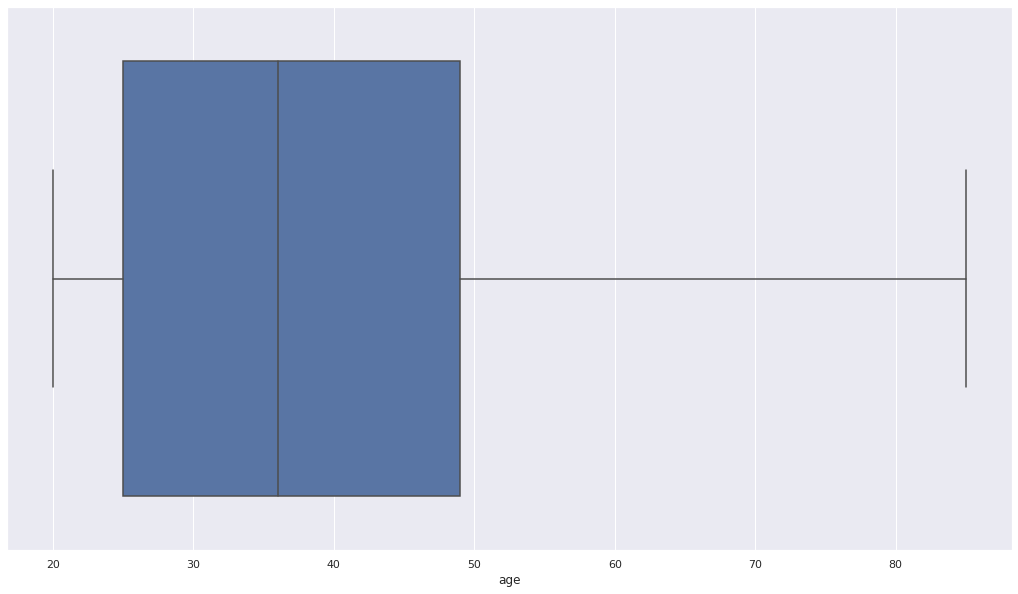

In [ ]:
sns.boxplot(x = 'age',  data = df1)

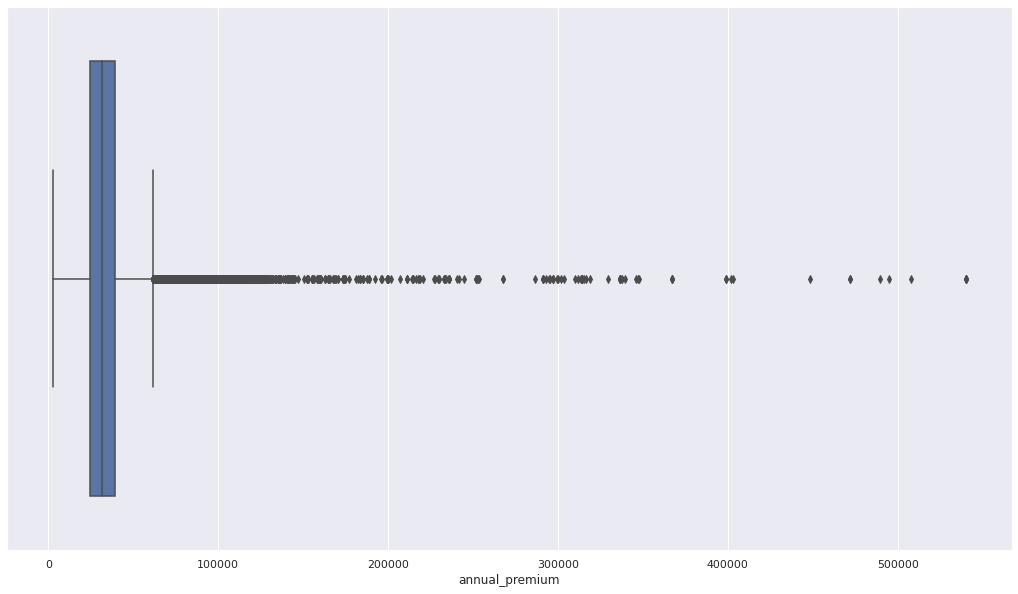

In [ ]:
sns.boxplot(x = 'annual_premium', data = df1)

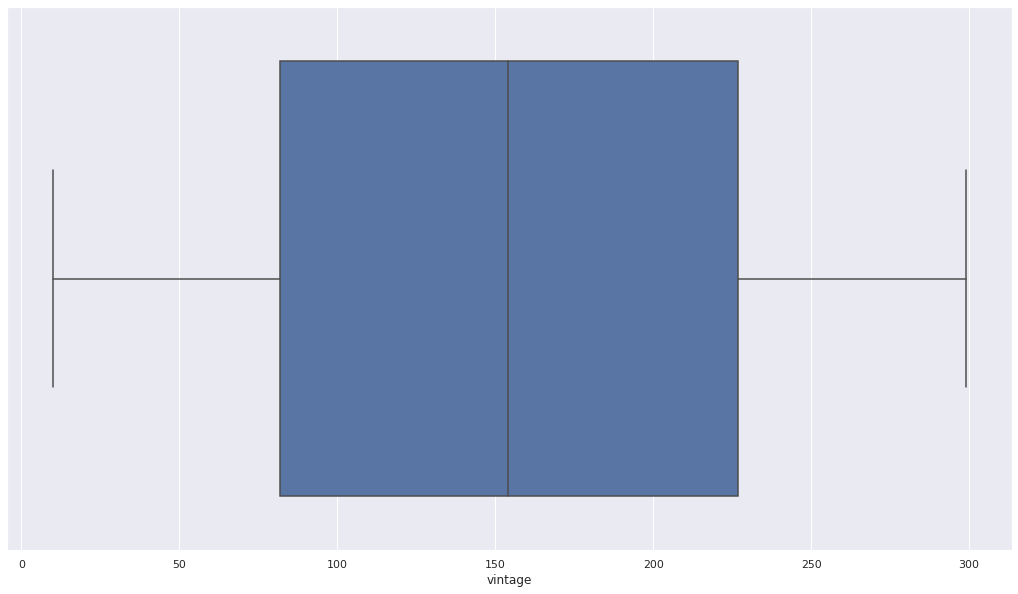

In [ ]:
sns.boxplot(x = 'vintage', data = df1)

### 1.8.2 Categorical Attributes

In [ ]:
cat_attributes.describe()

,gender,vehicle_age,vehicle_damage
count,304887,304887,304887
unique,2,3,2
top,Male,1-2 Year,Yes
freq,165032,160231,154022


## 1.9 Data Description Summary 

In [ ]:
num_attributes.columns

Index(['Index', 'id', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'previously_insured', 'annual_premium', 'vintage',
       'response'],
      dtype='object')

In [ ]:
summary_desc = pd.DataFrame( {
                              'Feature': ['age', 'region_code', 'policy_sales_channel', 'driving_license', 'previously_insured', 'annual_premium', 'vintage', 'response'],
                              'Outliers':['No' ,   'No'       ,     'No'              ,     'No'         ,         'No'        ,       'yes'     ,    'No'  ,     'No'] 
                              },
                            index = [1, 2, 3, 4, 5, 6, 7, 8] )

summary_desc

,Feature,Outliers
1,age,No
2,region_code,No
3,policy_sales_channel,No
4,driving_license,No
5,previously_insured,No
6,annual_premium,yes
7,vintage,No
8,response,No


## 1.10. Save

In [ ]:
df1.to_csv(path+'/Data/df2.csv', index_label = False)

# 2.0. Feature Engineering

In [ ]:
df2 = pd.read_csv(path+'/Data/df2.csv')

In [ ]:
df2.columns

Index(['Index', 'id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

## 2.1. Mind Map Hypothesis

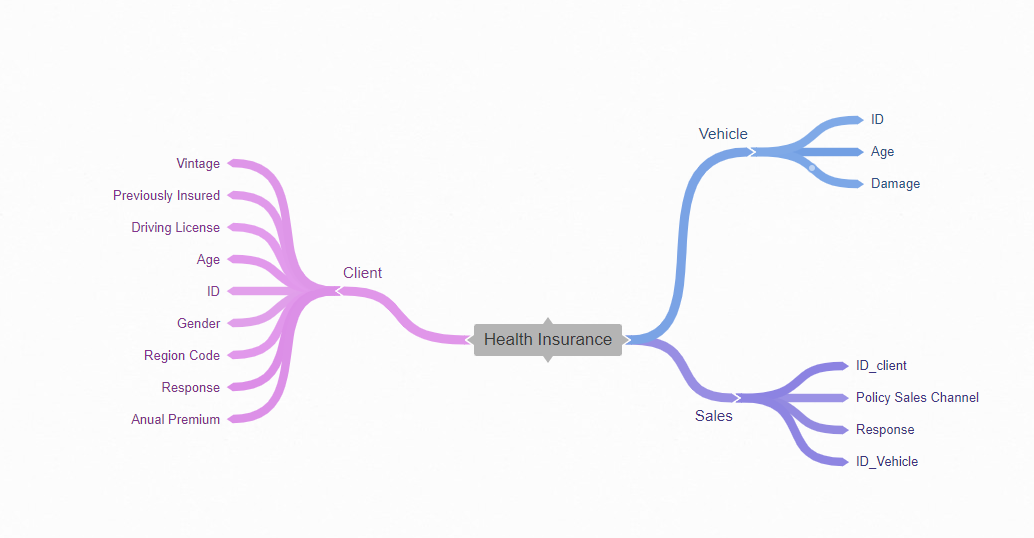

In [ ]:
Image('/content/drive/MyDrive/DataScience/Projects/Health Insurance/Image/MindMap.png')

## 2.2. Hypothesis Creation

### 2.2.1 Client

**1.** clients older then 30 have a bigger chance of get a health insurance

**2.** clients younger then 30 have a bigger chance get a healh insurance

**3.** Clients wich 'anual premium' is lower have a bigger chance of get a heath insurance

**4.** Clients wich 'anual premium' is higher have a bigger chance of get a heath insurance

**5.** Long date clients have a bigger chance of get a health insurance

**6.** clients with no driving license have a lower chance of get a health insurance

**7.** Clients with driving license have a bigger chance of get a health insurance

**8.** Mens have a bigger chance of get a health insurance

**9.** Womens have a bigger chance of get a health insurance



### 2.2.2 Vehicle

**10.** Clients with new cars have more chance of get the heath insurance

**11.** Clients with old cars have more chance of get the heath insurance

**12.** Clients with previously vehicle damage have a higher chance of get a health insurance

**13.** Clients with no previously vehicle damage have a higher chance of get a health insurance

## 2.3. Final Hypothesis

**1.** clients older then 30 have a bigger chance of get a health insurance

**2.** clients younger then 30 have a bigger chance get a healh insurance

**3.** Clients wich 'anual premium' is lower have a bigger chance of get a heath insurance

**4.** Clients wich 'anual premium' is higher have a bigger chance of get a heath insurance

**5.** Long date clients have a bigger chance of get a health insurance

**6.** clients with no driving license have a lower chance of get a health insurance

**7.** Clients with driving license have a bigger chance of get a health insurance

**8.** Mens have a bigger chance of get a health insurance

**9.** Womens have a bigger chance of get a health insurance

**10.** Clients with new cars have more chance of get the heath insurance

**11.** Clients with old cars have more chance of get the heath insurance

**12.** Clients with previously vehicle damage have a higher chance of get a health insurance

**13.** Clients with no previously vehicle damage have a higher chance of get a health insurance

## 2.4. Feature Engineering

In [ ]:
df2.head()

,Index,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,105515,105516,Male,44,36.0,124.0,1,1-2 Year,Yes,0,2630.0,90,0
1,157357,157358,Female,59,28.0,61.0,1,1-2 Year,Yes,0,54777.0,84,0
2,162327,162328,Female,44,12.0,26.0,1,1-2 Year,No,1,43569.0,207,0
3,143266,143267,Male,36,36.0,157.0,1,1-2 Year,Yes,0,2630.0,275,1
4,297026,297027,Male,55,37.0,128.0,1,1-2 Year,Yes,0,32199.0,264,0


In [ ]:
df2['driving_license'].replace( 0, 'no', inplace = True)
df2['driving_license'].replace( 1, 'yes', inplace = True)

df2['previously_insured'].replace( 0, 'no', inplace = True)
df2['previously_insured'].replace( 1, 'yes', inplace = True)

df2['response'].replace( 0, 'no', inplace = True)
df2['response'].replace( 1, 'yes', inplace = True)

df2.head()

,Index,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,105515,105516,Male,44,36.0,124.0,yes,1-2 Year,Yes,no,2630.0,90,no
1,157357,157358,Female,59,28.0,61.0,yes,1-2 Year,Yes,no,54777.0,84,no
2,162327,162328,Female,44,12.0,26.0,yes,1-2 Year,No,yes,43569.0,207,no
3,143266,143267,Male,36,36.0,157.0,yes,1-2 Year,Yes,no,2630.0,275,yes
4,297026,297027,Male,55,37.0,128.0,yes,1-2 Year,Yes,no,32199.0,264,no


## 2.5 Save

In [ ]:
df2.to_csv(path+'/Data/df3.csv', index_label = False)

# 3.0 Data Filtering

In [ ]:
df3 = pd.read_csv(path+'/Data/df3.csv')
df3.head(1)

,Index,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,105515,105516,Male,44,36.0,124.0,yes,1-2 Year,Yes,no,2630.0,90,no


## 3.1. Filtering Rows

## 3.2. Columns Selection

In [ ]:
df3.drop(['Index', 'id'], axis = 1, inplace = True)
df3.head()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,Male,44,36.0,124.0,yes,1-2 Year,Yes,no,2630.0,90,no
1,Female,59,28.0,61.0,yes,1-2 Year,Yes,no,54777.0,84,no
2,Female,44,12.0,26.0,yes,1-2 Year,No,yes,43569.0,207,no
3,Male,36,36.0,157.0,yes,1-2 Year,Yes,no,2630.0,275,yes
4,Male,55,37.0,128.0,yes,1-2 Year,Yes,no,32199.0,264,no


## 3.2. Save

In [ ]:
df3.to_csv(path+'/Data/df4.csv',index_label= False)

# 4.0. Exploratory Data Analysis

In [ ]:
df4 = pd.read_csv(path+'/Data/df4.csv')
df4.sample(1)

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
80294,Male,43,10.0,156.0,yes,1-2 Year,Yes,no,2630.0,170,no


## 4.1. Univariate Analysis

### 4.1.1 Response Variable

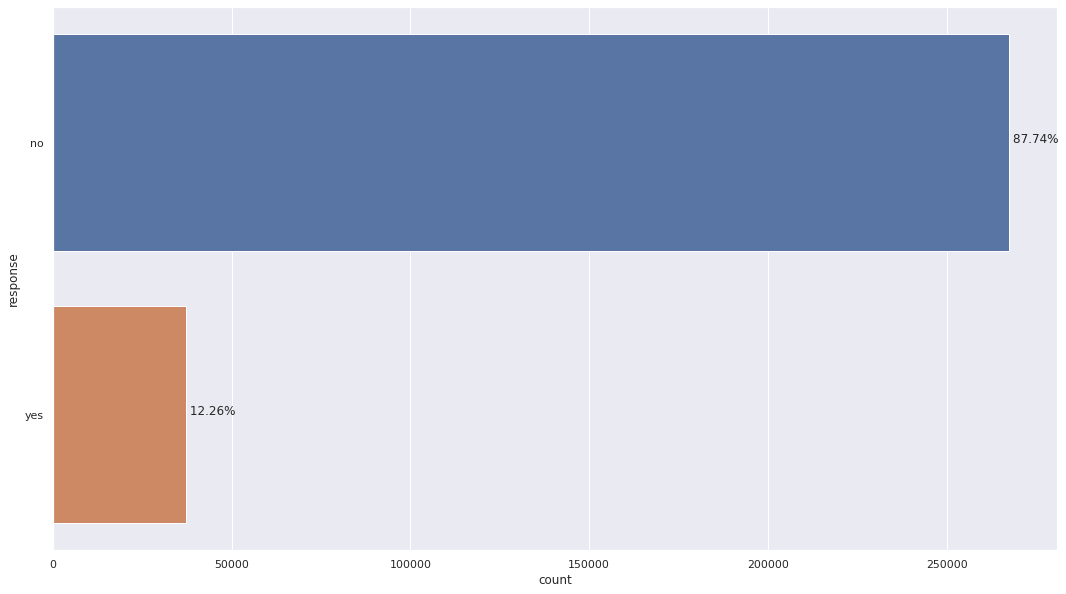

In [ ]:
ax = sns.countplot( y = 'response', data = df4)

total = df4['response'].size
for p in ax.patches:
  percentage = ' {:.2f}%'.format(100 * p.get_width() / total )
  x = p.get_x() + p.get_width()
  y = p.get_y() + p.get_height() / 2
  ax.annotate( percentage, (x, y) )
  plt.rcParams['figure.figsize'] = [18,10]


### 4.1.2 Numerical Variable

In [ ]:
num_attributes = df4.select_dtypes(exclude = 'object')

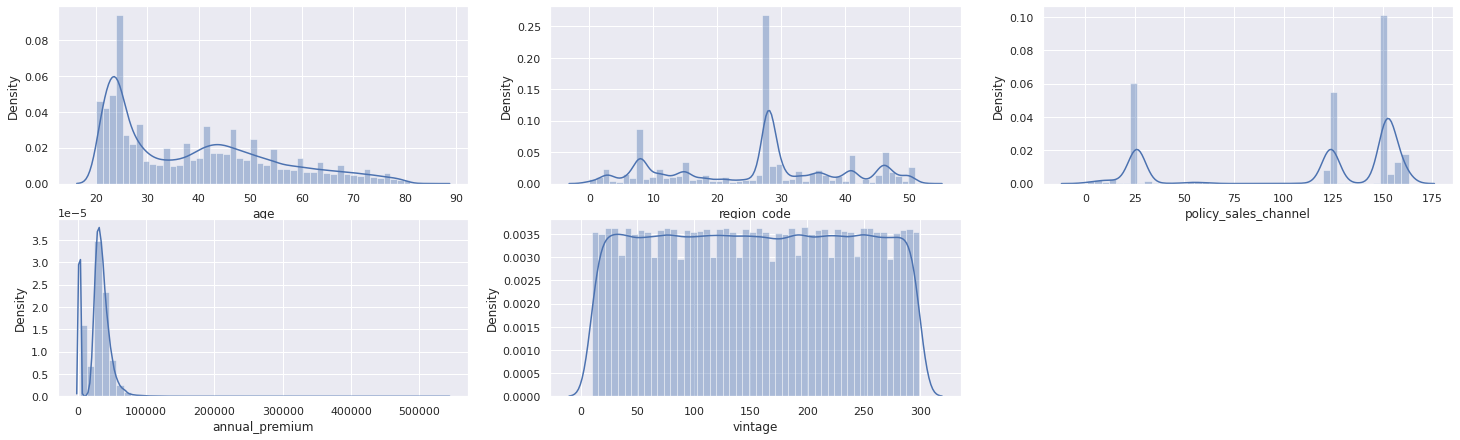

In [ ]:
num_a_columns = num_attributes.columns.tolist()
j = 1

for column in num_a_columns:
  plt.subplot(4, 3, j)
  sns.distplot(num_attributes[column] );
  j += 1
  plt.rcParams['figure.figsize'] = [40,28]

### 4.1.3 Categorical Variables

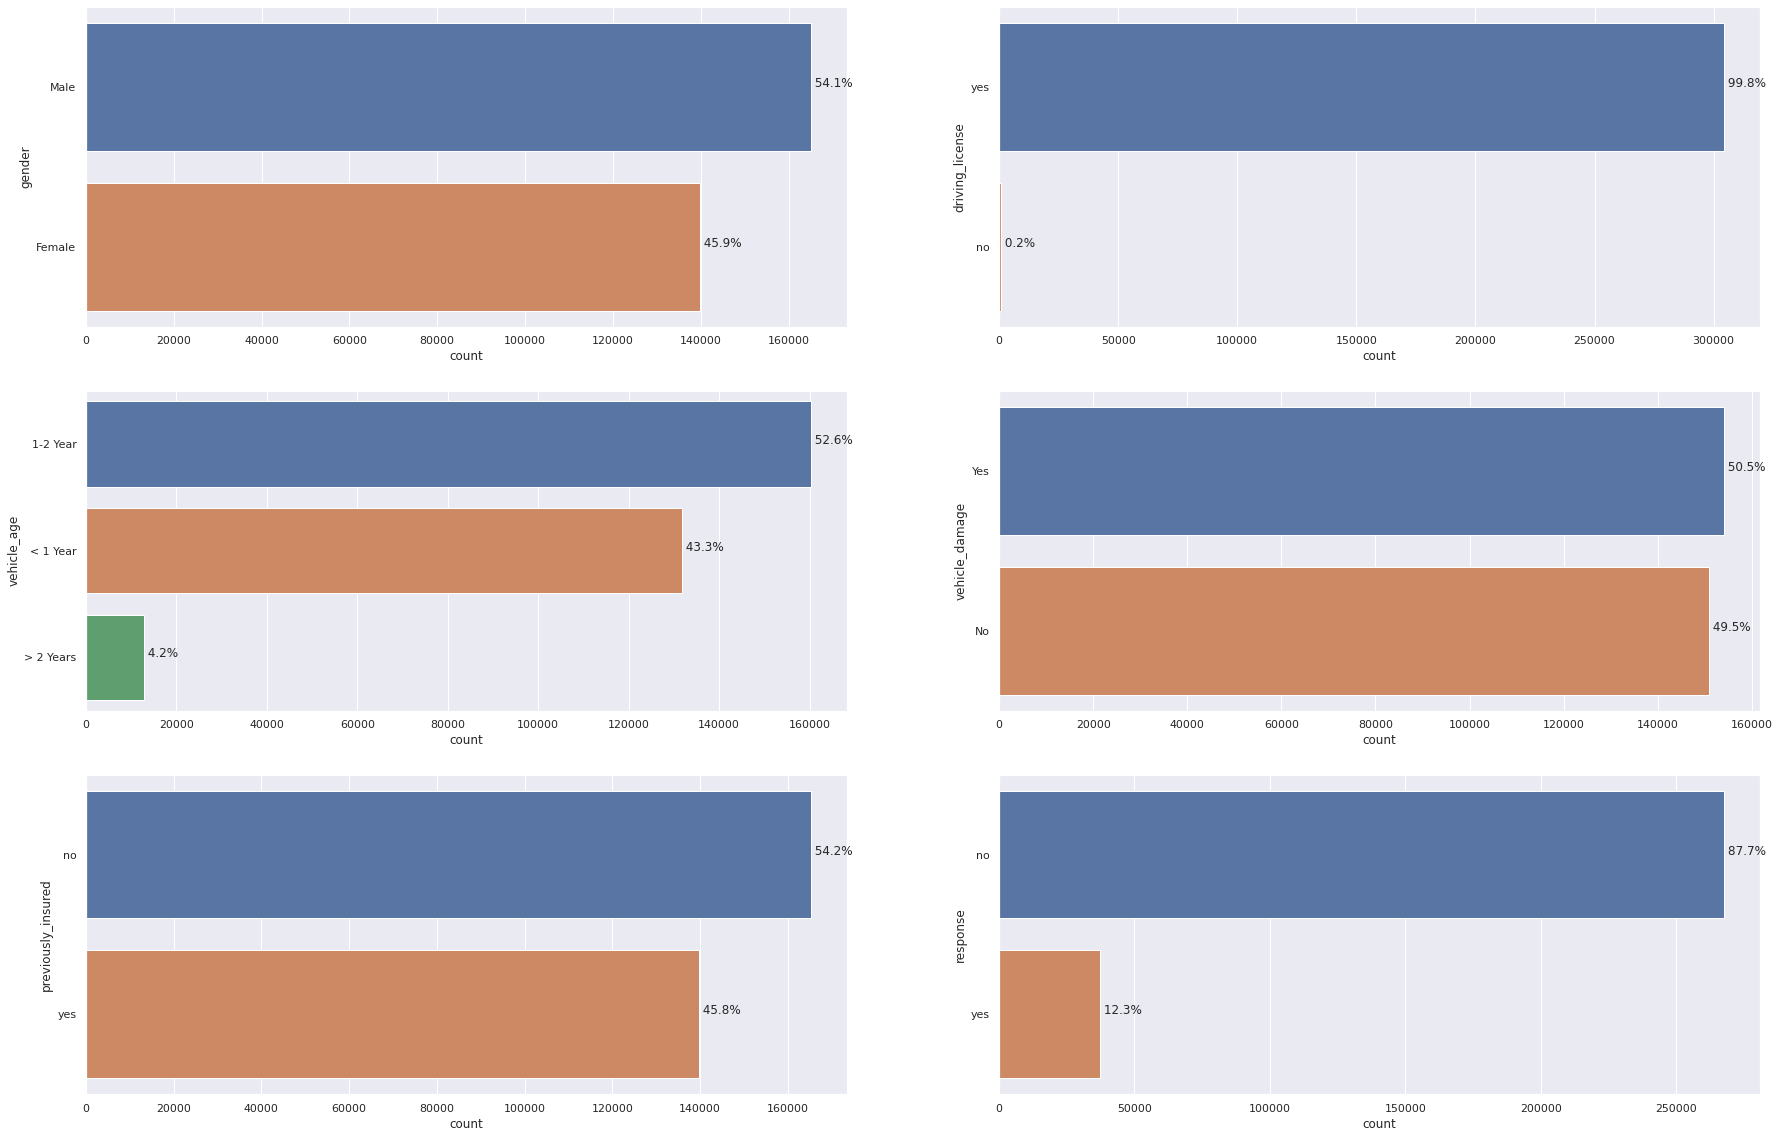

In [ ]:
cat_attributes = df4.select_dtypes(include = 'object')
cat_a_columns = cat_attributes.columns.tolist()

j = 1

for column in cat_a_columns:
  plt.subplot(3, 2, j)
  ax = sns.countplot(y=column, data=cat_attributes)
  plt.rcParams['figure.figsize'] = [25,15]
    
  total = cat_attributes[column].size
  for p in ax.patches:
      percentage = ' {:.1f}%'.format(100 * p.get_width()/total)
      x = p.get_x() + p.get_width() + 0.02
      y = p.get_y() + p.get_height()/2
      ax.annotate(percentage, (x, y))
    
  j += 1

## 4.2. Bivariate Analysis

**1.** clients older then 30 have a bigger chance of get a health insurance



In [ ]:
df4.sample()

,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
108671,Female,20,30.0,160.0,yes,< 1 Year,Yes,yes,22836.0,97,no


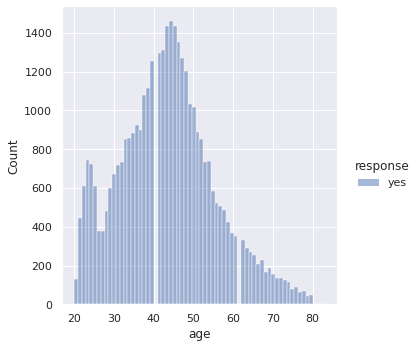

In [ ]:
a = df4[df4['response'] == 'yes']
sns.displot( x = 'age', data = a, hue = 'response')
plt.rcParams['figure.figsize'] = [25,20]

**2.** clients younger then 30 have a bigger chance get a healh insurance

**3.** Clients wich 'anual premium' is lower have a bigger chance of get a heath insurance

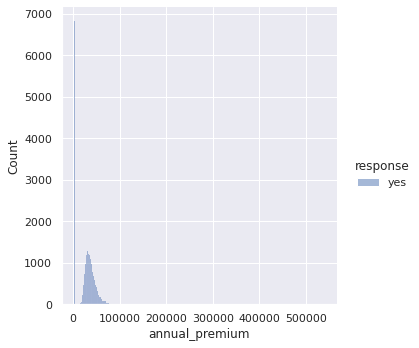

In [ ]:
a = df4[df4['response'] == 'yes']
sns.displot( x = 'annual_premium', data = a, hue = 'response')
plt.rcParams['figure.figsize'] = [25,20]

**4.** Clients wich 'anual premium' is higher have a bigger chance of get a heath insurance



**5.** Long date clients have a bigger chance of get a health insurance



**6.** clients with no driving license have a lower chance of get a health insurance



**7.** Clients with driving license have a bigger chance of get a health insurance



**8.** Mens have a bigger chance of get a health insurance



**9.** Womens have a bigger chance of get a health insurance



**10.** Clients with new cars have more chance of get the heath insurance



**11.** Clients with old cars have more chance of get the heath insurance



**12.** Clients with previously vehicle damage have a higher chance of get a health insurance



**13.** Clients with no previously vehicle damage have a higher chance of get a health insurance

## 4.3. Multivariaty Analysis

In [ ]:
df4['driving_license'].replace( 'no', 0, inplace = True)
df4['driving_license'].replace( 'yes', 1, inplace = True)

df4['previously_insured'].replace( 'no', 0, inplace = True)
df4['previously_insured'].replace( 'yes', 1, inplace = True)

df4['response'].replace( 'no', 0, inplace = True)
df4['response'].replace( 'yes', 1, inplace = True)

In [ ]:
num_attributes = df4.select_dtypes( include = ['int64', 'float64'] )
cat_attributes = df4.select_dtypes( exclude = ['int64', 'float64'] )

### 4.3.1 Numerical Analysis

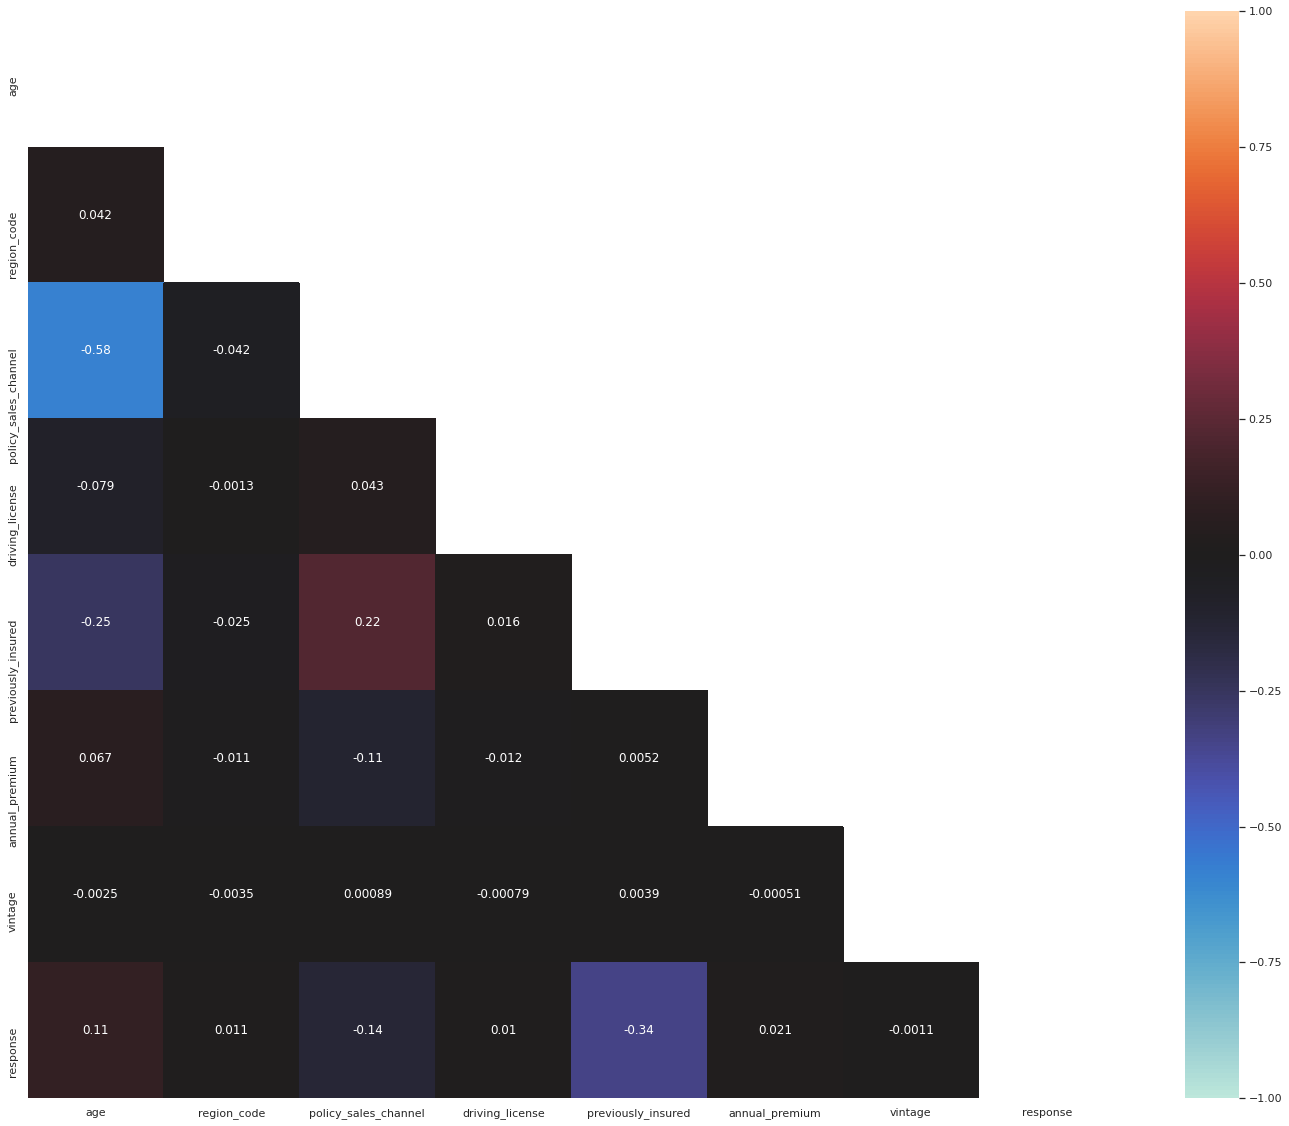

In [ ]:
corr = num_attributes.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style('white'):
  ax = sns.heatmap(corr, annot = True, mask = mask, vmin = -1, center = 0, vmax = 1, square = True)

### 4.3.2 Categorical Variables

In [ ]:
# corr = cat_attributes.corr()

# mask = np.zeros_like(corr)
# mask[np.triu_indices_from(mask)] = True

# with sns.axes_style('white'):
#   ax = sns.heatmap(corr, annot = True, mask = mask, vmin = -1, center = 0, vmax = 1, square = True)

### 4.3.3 Save

In [ ]:
df4.to_csv(path+'/Data/df5.csv',index_label= False)

# 5.0. Data Preparation

In [18]:
df5 = pd.read_csv(path+'/Data/df5.csv')

In [19]:
X_train = df5.drop('response', axis = 1 )
y_train = pd.read_csv(path+'/Data/test.csv')
y_train = y_train['response']



## 5.1. Standardization

In [26]:
ss = pp.StandardScaler()

#annual_premium
df5['annual_premium'] = ss.fit_transform( df5[['annual_premium']].values )

## 5.2. Rescaling

In [28]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

#Age
df5['age'] = mms_age.fit_transform( df5[['age']].values)

#Vintage
df5['vintage'] = mms_vintage.fit_transform( df5[['vintage']].values)

## 5.3. Encoder

In [ ]:
# gender
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:, 'gender'] = df5['gender'].map( target_encode_gender )

# region_code
target_encode_region_code = df5.groupby( 'region_code')['response'].mean()
df5.loc[:, 'regoin_code'] = df5['region_code'].map(target_encode_region_code)

#vehicle_age
df5 = pd.get_dummies( df5, prefix = 'vehicle_age', columns = ['vehicle_age'] )

# policy_sales_channel
fe_policy_sales_channel = df5.groupby( 'policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map( fe_policy_sales_channel )


## 5.4 Validation Preparation

# 6.0. Feature Selection

# 7.0 Machine Learning Model